In [99]:
# Importación de librerías necesarias
import os  # Librería del sistema operativo para interactuar con el sistema operativo
import numpy as np  # Biblioteca para operaciones matemáticas en matrices y arreglos
import pandas as pd  # Librería para la manipulación y análisis de estructuras de datos y operaciones de análisis

# Herramientas de preprocesamiento de Keras
from keras_preprocessing.sequence import pad_sequences  # Función para hacer que las secuencias tengan la misma longitud

# Componentes principales y capas de Keras para construir modelos de redes neuronales
from keras import Sequential  # Modelo lineal apilado de capas para construir redes neuronales
from keras.layers import (
    Activation,  # Capa que aplica una función de activación a la salida
    Dropout,  # Capa que aplica regularización al modelo, evitando el sobreajuste
    Dense,  # Capa completamente conectada para aprendizaje profundo
    Flatten,  # Capa para convertir la entrada multidimensional en una dimensión
    Conv1D,  # Capa de convolución 1D, comúnmente usada para procesamiento de señales o series temporales
    LSTM,  # Variante de RNN, diseñada para aprender de secuencias largas
    GlobalMaxPooling1D,  # Operación de agrupación máxima a nivel global
    Embedding  # Capa para convertir palabras en vectores
)

# Herramientas para la conversión y preparación de datos
from keras.utils import to_categorical  # Convierte un vector de clase en una matriz binaria de clase
from sklearn.model_selection import train_test_split  # Divide datos en conjuntos de entrenamiento y prueba

# Herramientas de procesamiento de texto
from keras.preprocessing.text import Tokenizer  # Convierte textos en secuencias de números
from nltk.tokenize import RegexpTokenizer  # Tokenizador que usa expresiones regulares para dividir texto
from nltk.tokenize.treebank import TreebankWordDetokenizer  # Detokenizador para convertir listas de palabras en texto

# Herramientas de visualización
import matplotlib.pyplot as plt  # Biblioteca para gráficos y visualizaciones

# Funciones adicionales de numpy para la manipulación de datos
from numpy import asarray  # Convierte estructuras dadas a arreglos numpy
from numpy import zeros  # Crea un arreglo de ceros con forma y tipo de dato especificados
from numpy import array  # Crea un arreglo

# Se importa nuevamente pad_sequences y Sequential, lo cual es redundante ya que fueron importados anteriormente
from keras_preprocessing.sequence import pad_sequences
from keras import Sequential


##  Paso 1 Lectura del Corpus

In [100]:
### Consolidamos todos los textos en un archivo CSV para el preprocesamiento

# Especifica la ruta al directorio principal que contiene las carpetas con diferentes categorías de texto
directorio_principal = './Textos_para_Clasificar'

# Inicializa una lista vacía para almacenar los datos recolectados
datos = []

# Itera sobre cada carpeta (representando una categoría) en el directorio principal
for categoria in os.listdir(directorio_principal):
    # Combina la ruta del directorio principal con la carpeta de la categoría para obtener la ruta completa
    ruta_categoria = os.path.join(directorio_principal, categoria)
    
    # Verifica si la ruta especificada realmente corresponde a un directorio
    if os.path.isdir(ruta_categoria):
        
        # Itera sobre cada archivo en la carpeta de la categoría actual
        for archivo in os.listdir(ruta_categoria):
            # Combina la ruta de la carpeta de categoría con el nombre del archivo para obtener la ruta completa
            ruta_archivo = os.path.join(ruta_categoria, archivo)
            
            # Abre y lee el contenido del archivo de texto
            with open(ruta_archivo, 'r', encoding='utf-8') as f:
                texto = f.read()
                # Añade el contenido del archivo (texto) y la categoría correspondiente a la lista de datos
                datos.append([texto, categoria])

# Convierte la lista de datos en un DataFrame usando pandas
df = pd.DataFrame(datos, columns=['Texto', 'Categoría'])

# Guarda el DataFrame en un archivo CSV sin índices
df.to_csv('datos_clasificador.csv', index=False)

# Imprime el DataFrame para visualizar el resultado
print(df)


                                                Texto Categoría
0   Águila es el nombre dado a las mayores aves de...  Animales
1   ﻿Crocodylidae (castellanizado como crocodílido...  Animales
2   Los delfines (Delphinidae), llamados también d...  Animales
3   Los elefantes o elefántidos (Elephantidae) son...  Animales
4   Los quirópteros (Chiroptera), conocidos comúnm...  Animales
5   Los vulpinos (Vulpini) son una tribu de mamífe...  Animales
6   Iniciada en 1848 con el descubrimiento de oro ...   Eventos
7   El 12 de octubre de 1492, Cristóbal Colón, un ...   Eventos
8   Conocido también como el Día D, el Desembarco ...   Eventos
9   Iniciada en 1848 con el descubrimiento de oro ...   Eventos
10  El 20 de julio de 1969, la misión Apollo 11 de...   Eventos
11  La Revolución Francesa fue un período de agita...   Eventos
12  Alemania, oficialmente República Federal de Al...   Lugares
13  Australia, oficialmente Mancomunidad de Austra...   Lugares
14  Canadá (Canada) es un país soberano 

<BarContainer object of 5 artists>

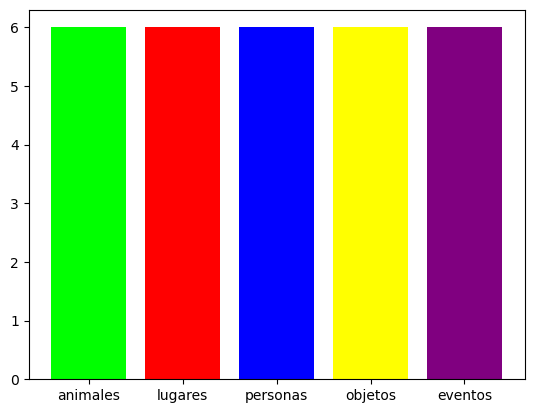

In [101]:
# Inicialización de contadores para cada categoría
# Estos contadores registrarán la cantidad de textos por cada categoría en el DataFrame
animales = 0
lugares = 0
personas = 0
objetos = 0
eventos = 0

# Itera sobre cada entrada en la columna 'Categoría' del DataFrame
for text in df["Categoría"]:
    # Basándose en el valor de la categoría, incrementa el contador correspondiente
    if text == 'Animales':
        animales += 1
    elif text == 'Lugares':
        lugares += 1
    elif text == 'Personas':
        personas += 1
    elif text == 'Objetos':
        objetos += 1
    elif text == 'Eventos':
        eventos += 1

# Visualización:
# Utiliza matplotlib para crear un gráfico de barras que muestra la distribución de textos por categoría
plt.bar(
    ['animales', 'lugares', 'personas', 'objetos', 'eventos'],  # Etiquetas para el eje X, representando cada categoría
    [animales, lugares, personas, objetos, eventos],  # Valores de las barras, que corresponden al número de textos por categoría
    color = ['lime', 'red', 'blue', 'yellow', 'purple']  # Colores asignados a cada barra/categoría
)


### Paso 2: Preprocesamiento

In [102]:
# Importación de las herramientas necesarias
from nltk.tokenize import RegexpTokenizer  # Herramienta para tokenizar evitando signos de puntuación
from nltk.tokenize.treebank import TreebankWordDetokenizer  # Herramienta para convertir tokens de vuelta a texto
from nltk.corpus import stopwords  # Conjunto de stopwords en diferentes idiomas
import re  # Módulo para trabajar con expresiones regulares

# Carga las stopwords en español
stop_words = set(stopwords.words('spanish'))

# Lista para almacenar los textos preprocesados
X = []

# Obtiene todos los textos del DataFrame
textos = list(df['Texto'])
for text in textos:
    
    sentence = text
    # Filtrado de stopwords: Reemplaza cada stopword en el texto con un espacio en blanco
    for stopword in stop_words:
        sentence = sentence.replace(" " + stopword + " ", " ")

    # Remueve espacios múltiples dejando solo uno
    sentence = re.sub(r'\s+', ' ', sentence)
    # Convierte el texto a minúsculas
    sentence = sentence.lower()
    # Inicializa el tokenizador para rechazar signos de puntuación
    tokenizer = RegexpTokenizer(r'\w+')
    # Tokeniza el texto
    result = tokenizer.tokenize(sentence)
    # Une los tokens en un único string y lo añade a la lista X
    X.append(TreebankWordDetokenizer().detokenize(result))
    # Elimina acentos en las vocales
    X = [re.sub(r'[á]', 'a', i) for i in X]
    X = [re.sub(r'[é]', 'e', i) for i in X]
    X = [re.sub(r'[í]', 'i', i) for i in X]
    X = [re.sub(r'[ó]', 'o', i) for i in X]
    X = [re.sub(r'[ú]', 'u', i) for i in X]

# Imprime los textos preprocesados para verificar que se haya realizado el filtrado correctamente
for i in range(0, len(X)):
    print(X[i])

# Imprime el número de palabras en cada texto preprocesado
for i in range(0, len(X)):
    print(len(X[i].split()))


aguila nombre dado mayores aves depredadoras las diversas especies subespecies aguilas pueden encontrarse casi cualquier parte mundo excepto antartida son miembros aves presa orden accipitriformes o falconiformes acorde clasificacion anterior familia accipitridae subfamilia buteoninae pertenecen varios generos cuales sujetos reclasificacion adecuada puesto expertos llegan opinion consensuada las aguilas caracterizan principalmente gran tamaño constitucion robusta cabeza pico pesados como todas aves presa aguilas poseen pico grande poderoso puntiagudo desprender carne presa cuentan tarsos garras poderosas llama atencion fuerza aguilas posibilita alzar vuelo presas pesadas ellas ademas poseen vista extremadamente aguda permite visualizar potenciales presas distancia ejemplo aguila real posee dos puntos focales ojos mirar frente localizar mirada hacia costados escudriñando distancia las aguilas sido utilizadas pueblos simbolo nacional especialmente simbolo imperial mostrando poderio belle

## Paso 3 - Creación de vectores / matrices de entrada y salida para el entrenamiento

In [103]:
# Importación de las categorías desde el DataFrame
Categorias = df['Categoría']  # Extrae la columna 'Categoría' del DataFrame

# Inicializa una lista vacía para almacenar las categorías transformadas a valores numéricos
y = []

# Recorre cada categoría en la lista de categorías
for categoria in Categorias:
    # Convierte las categorías textuales a una representación numérica
    # y agrega el valor numérico correspondiente a la lista 'y'
    if categoria == "Animales":
        y.append(0)  # Asigna el valor 0 a la categoría "Animales"
    elif categoria == "Lugares":
        y.append(1)  # Asigna el valor 1 a la categoría "Lugares"
    elif categoria == "Personas":
        y.append(2)  # Asigna el valor 2 a la categoría "Personas"
    elif categoria == "Objetos":
        y.append(3)  # Asigna el valor 3 a la categoría "Objetos"
    elif categoria == "Eventos":
        y.append(4)  # Asigna el valor 4 a la categoría "Eventos"

# Imprime la lista 'y' para verificar la correcta conversión de categorías a valores numéricos
print("Vector de objetivos:")
print(y)


Vector de objetivos:
[0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2]


In [104]:
# Importa la función necesaria para dividir el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Divide el conjunto de datos en conjuntos de entrenamiento y prueba
# Se asigna el 10% de los datos al conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

# Inicializa un tokenizador que se utilizará para convertir palabras en números. 
# Se limita a las 100 palabras/tokens más comunes.
tokenizer = Tokenizer(num_words=100)

# Ajusta el tokenizador a los datos de entrenamiento.
# Esto implica que el tokenizador crea un diccionario de palabras basado en el conjunto de entrenamiento.
tokenizer.fit_on_texts(X_train)

# Usa el tokenizador para convertir las palabras en los conjuntos de entrenamiento y prueba 
# a sus respectivos índices numéricos.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Imprime la primera secuencia de palabras convertida en índices numéricos del conjunto de entrenamiento.
print(X_train[0])


[1, 96, 69, 7, 97, 1, 21, 13, 50, 3, 70, 98, 51, 22, 36, 52, 14, 1, 71, 37, 72, 73]


In [105]:
# Verificar que la información de entrada sea coherente
print(X_train)
print(y_train)

[[1, 96, 69, 7, 97, 1, 21, 13, 50, 3, 70, 98, 51, 22, 36, 52, 14, 1, 71, 37, 72, 73], [4, 99, 70, 98, 53, 2, 4, 99, 74, 53, 4, 99, 23, 24, 3], [12, 54, 29, 54, 5, 54, 29, 12], [75, 75, 2, 25, 38, 53, 55, 26, 56, 76, 26, 39, 25, 70, 74, 25, 22, 36, 21, 2, 3, 56, 16, 3, 1, 56, 75, 9, 77, 40, 14, 12, 52, 76, 75, 55, 78, 5, 75, 53, 21, 55, 75, 79, 79, 79, 80, 41, 30, 22, 36, 12, 57, 96, 81, 81, 21, 82], [6, 6, 2, 83, 6, 25, 25, 83, 83, 7, 58, 6, 59, 1, 4, 2, 84, 6, 2, 85, 6, 86, 1, 13, 39, 5, 3, 50, 78, 39, 31, 3, 7, 60, 6, 4, 86, 9, 4, 23, 6, 9, 6, 58, 12, 9, 2, 77, 85, 9, 40, 32, 6, 16, 9, 14, 14, 14, 24, 6, 32, 4, 61, 14, 17, 61, 14, 24, 6, 6, 53, 6, 80, 41, 5, 5, 29, 6, 14, 61, 14, 24, 5, 24, 21, 57, 81, 6, 2, 51, 61, 5, 82, 2, 3], [1, 18, 5, 42, 5, 1, 85, 18, 80, 7, 15, 8, 7, 43, 15, 15, 8, 15, 15, 15, 30, 60, 40, 15, 8, 54, 15, 15, 8, 30], [27, 10, 44, 41, 19, 78, 80, 50, 33, 12, 27, 16, 87, 85, 45, 62, 27, 27, 30, 7, 87, 44, 88, 63, 87], [7, 27, 63, 62, 63, 62, 76, 10, 27, 89, 89, 7

## Paso 4: Generación de Embeddings

In [106]:
# Declaración de librerías para manejo de arreglos (Numpy)
from numpy import asarray
from numpy import zeros

# Lectura del archivo de embeddings
embeddings_dictionary = dict()
Embeddings_file = open('./Word2Vect_Spanish.txt', encoding="utf8")

# Extraemos las características del archivo de embeddings
# y las agregamos a un diccionario (Cada elemento es un vextor)
for linea in Embeddings_file:
    caracts = linea.split()
    palabra = caracts[0]
    vector = asarray(caracts[1:], dtype='float32')
    embeddings_dictionary [palabra] = vector
Embeddings_file.close()

In [107]:
# Extraemos la cantidad de palabras en el vocabulario
vocab_size = len(tokenizer.word_index) + 1

# Generamos la matriz de embeddings (De entrada)
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    # Extraemos el vector de embedding para cada palabra
    embedding_vector = embeddings_dictionary.get(word)
    # Si la palbra si existía en el vocabulario
    # agregamos su vector de embeddings en la matriz
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Paso 5: Aplicación del Modelo DNN

In [108]:
# Importa la función necesaria para ajustar la longitud de las secuencias
from keras_preprocessing.sequence import pad_sequences

# Define la longitud máxima que deberán tener todas las secuencias
maxlen = 150

# Usa la función 'pad_sequences' para ajustar la longitud de las secuencias de entrenamiento y prueba.
# Si una secuencia es más corta que 'maxlen', se añadirán ceros al final (debido a padding='post').
# Si una secuencia es más larga que 'maxlen', se truncará a la longitud de 'maxlen'.
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Imprime la primera secuencia ajustada del conjunto de entrenamiento para verificar el proceso.
# También muestra el tamaño de la matriz de entrenamiento (número de secuencias x longitud de secuencia).
print("Matriz de valores para las palabras:")
print(X_train.shape)  # Imprime la forma (dimensión) de la matriz de entrenamiento


Matriz de valores para las palabras:
(27, 150)


In [109]:
# Importar herramientas necesarias de Keras y Scikit-Learn
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical

# Paso 1: Definir la función que crea el modelo Keras
def create_model(optimizer='adam', neurons=64):
    # Inicializar un modelo secuencial
    model = Sequential()
    # Agregar una capa de incrustación que utilice una matriz de incrustación predefinida
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    # Aplanar la salida de la capa de incrustación
    model.add(Flatten())
    # Agregar una capa densa con un número variable de neuronas y activación ReLU
    model.add(Dense(neurons, activation='relu'))
    # Capa de salida con 5 neuronas (para 5 clases) y activación softmax
    model.add(Dense(5, activation='softmax'))
    # Compilar el modelo
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    return model

# Envolver el modelo Keras para que sea compatible con Scikit-Learn
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

# Paso 2: Establecer los valores de hiperparámetros que se desean probar
param_grid = {
    'optimizer': ['SGD', 'Adam', 'RMSprop', 'Adagrad'],
    'neurons': [32, 64, 128, 256, 512],
    'batch_size': [5, 10, 20, 40, 80],
    'epochs': [10, 20, 30, 40],
}

# Paso 3: Inicializar GridSearchCV con el modelo, los hiperparámetros y validación cruzada de 3 pliegues
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# Entrenar el modelo con la combinación de hiperparámetros
grid_result = grid.fit(np.array(X_train), to_categorical(np.array(y_train)))

# Paso 4: Imprimir los resultados
# Mostrar la mejor puntuación obtenida y los hiperparámetros correspondientes
print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\eubgo\AppData\Local\Temp\ipykernel_20352\755979941.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)
C:\Users\eubgo\.conda\envs\NLP\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor: 0.592593 usando {'batch_size': 5, 'epochs': 20, 'neurons': 512, 'optimizer': 'Adam'}


In [110]:
# # Importamos la función necesaria para convertir las etiquetas en codificación one-hot
# from keras.utils import to_categorical
# 
# # Convertimos las listas de datos y etiquetas de entrenamiento y prueba a arrays de numpy
# y_train_np = np.array(y_train)
# X_train_np = np.array(X_train)
# y_test_np = np.array(y_test)
# X_test_np = np.array(X_test)
# 
# # Codificamos las etiquetas (clases) de entrenamiento y prueba en formato one-hot.
# # Dado que tenemos 5 clases, el tamaño de la codificación one-hot será de 5.
# y_train_onehot = to_categorical(y_train_np, num_classes=5)
# y_test_onehot = to_categorical(y_test_np, num_classes=5)
# 
# # Ajustamos el modelo a los datos de entrenamiento
# # Se usa un tamaño de lote de 10, durante 30 épocas, y se reserva el 10% de los datos para validación.
# # El nivel de verbosity se establece en 3, que normalmente no muestra nada (depende de la versión y configuración de Keras).
# history = model.fit(X_train_np, y_train_onehot, batch_size=10, epochs=30, verbose=3, validation_split=0.10)
# 
# # Evaluamos el desempeño del modelo en el conjunto de datos de prueba
# score = model.evaluate(X_test_np, y_test_onehot, verbose=3)
# 
# # Imprimimos la pérdida y precisión del modelo en el conjunto de datos de prueba
# print("Test Loss:", score[0])
# print("Test Accuracy:", score[1])


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


AttributeError: 'KerasClassifier' object has no attribute 'evaluate'

In [ ]:
# # Importamos la biblioteca necesaria para graficar
# import matplotlib.pyplot as plt
# 
# # Graficamos la precisión (accuracy) del modelo a lo largo de las épocas
# plt.plot(history.history['acc'])  # Precisión en el conjunto de entrenamiento
# plt.plot(history.history['val_acc'])  # Precisión en el conjunto de validación
# 
# plt.title('model accuracy')  # Título del gráfico
# plt.ylabel('accuracy')  # Etiqueta del eje y
# plt.xlabel('epoch')  # Etiqueta del eje x
# plt.legend(['train','test'], loc='upper left')  # Leyenda para diferenciar entre entrenamiento y validación
# plt.show()  # Mostramos el gráfico de precisión
# 
# # Graficamos la pérdida (loss) del modelo a lo largo de las épocas
# plt.plot(history.history['loss'])  # Pérdida en el conjunto de entrenamiento
# plt.plot(history.history['val_loss'])  # Pérdida en el conjunto de validación
# 
# plt.title('model loss')  # Título del gráfico
# plt.ylabel('loss')  # Etiqueta del eje y
# plt.xlabel('epoch')  # Etiqueta del eje x
# plt.legend(['train','test'], loc='upper left')  # Leyenda para diferenciar entre entrenamiento y validación
# plt.show()  # Mostramos el gráfico de pérdida


KeyError: 'val_acc'

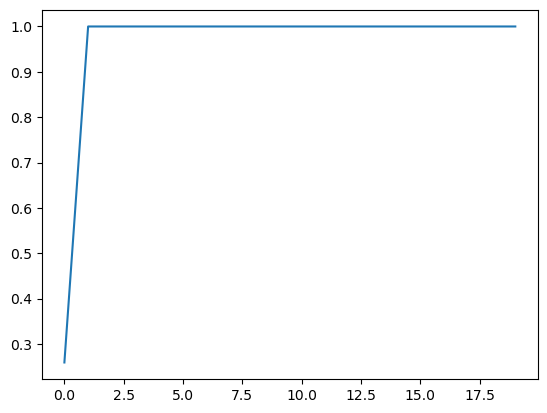

In [111]:
# Obtener el mejor modelo de GridSearchCV
best_model = grid_result.best_estimator_.model

# Graficamos la precisión (accuracy) del mejor modelo a lo largo de las épocas
plt.plot(best_model.history.history['acc'])  # Precisión en el conjunto de entrenamiento
plt.plot(best_model.history.history['val_acc'])  # Precisión en el conjunto de validación

plt.title('Best Model Accuracy')  # Título del gráfico
plt.ylabel('accuracy')  # Etiqueta del eje y
plt.xlabel('epoch')  # Etiqueta del eje x
plt.legend(['train','test'], loc='upper left')  # Leyenda para diferenciar entre entrenamiento y validación
plt.show()  # Mostramos el gráfico de precisión

# Graficamos la pérdida (loss) del mejor modelo a lo largo de las épocas
plt.plot(best_model.history.history['loss'])  # Pérdida en el conjunto de entrenamiento
plt.plot(best_model.history.history['val_loss'])  # Pérdida en el conjunto de validación

plt.title('Best Model Loss')  # Título del gráfico
plt.ylabel('loss')  # Etiqueta del eje y
plt.xlabel('epoch')  # Etiqueta del eje x
plt.legend(['train','test'], loc='upper left')  # Leyenda para diferenciar entre entrenamiento y validación
plt.show()  # Mostramos el gráfico de pérdida


## Paso 6: Aplicación del modelo CNN

In [ ]:
# Declaración de modelo Secuencial 
model = Sequential()

y_train_onehot = to_categorical(y_train_np, num_classes=5)
y_test_onehot = to_categorical(y_test_np, num_classes=5)
# Declaración de las capas del modelo convolucional
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Dense(64, activation='relu'))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='softmax'))
# Impresión de parámetros del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

In [ ]:
# Utilizamos el método fit para ajustar los datos de nuestro modelo a la configuración que definimos
history = model.fit(X_train_np, y_train_onehot, batch_size=10, epochs=30, verbose=1, validation_split=0.2)
# Utilizamos evaluate para determinar la pérdida y el accuracy de nuestro modelo
score = model.evaluate(X_test_np, y_test_onehot, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Graficamos la precisión (accuracy) del modelo durante el entrenamiento y validación
plt.plot(history.history['acc'])  # Precisión del conjunto de entrenamiento
plt.plot(history.history['val_acc'])  # Precisión del conjunto de validación

plt.title('model accuracy')  # Título del gráfico
plt.ylabel('accuracy')  # Etiqueta del eje y
plt.xlabel('epoch')  # Etiqueta del eje x
plt.legend(['train','test'], loc='upper left')  # Leyenda del gráfico
plt.show()  # Mostrar el gráfico

# Graficamos la pérdida (loss) del modelo durante el entrenamiento y validación
plt.plot(history.history['loss'])  # Pérdida del conjunto de entrenamiento
plt.plot(history.history['val_loss'])  # Pérdida del conjunto de validación

plt.title('model loss')  # Título del gráfico
plt.ylabel('loss')  # Etiqueta del eje y
plt.xlabel('epoch')  # Etiqueta del eje x
plt.legend(['train','test'], loc='upper left')  # Leyenda del gráfico
plt.show()  # Mostrar el gráfico

## Paso 7: LSTM

In [ ]:
# Declaración de un modelo de tipo Secuencial en Keras
model = Sequential()

# Añadir una capa de embedding al modelo. Esta capa convierte las palabras en vectores densos.
# Se inicializa con una matriz de embedding preentrenada (`embedding_matrix`), y se configura para que sus pesos puedan ser ajustados durante el entrenamiento.
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=True)
model.add(embedding_layer)

# Añadir una capa LSTM con 64 unidades al modelo.
model.add(LSTM(64))

# Añadir una capa densa de salida con 4 unidades (suponiendo 4 clases) y una función de activación softmax.
model.add(Dense(5, activation='softmax'))

# Compilar el modelo. Se utiliza el optimizador 'adam', la pérdida de 'categorical_crossentropy' (adecuada para clasificación multiclase),
# y se monitoriza el accuracy como métrica.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Imprimir un resumen del modelo, mostrando la arquitectura y número de parámetros.
print(model.summary())


In [ ]:
# Ajustamos el modelo a los datos de entrenamiento
history = model.fit(X_train_np, y_train_onehot, batch_size=10, epochs=30, verbose=1, validation_split=0.2)  # Entrena el modelo con un tamaño de lote de 10, durante 30 épocas, mostrando logs y usando el 20% de los datos para validación.

# Evaluamos el desempeño del modelo en los datos de prueba
score = model.evaluate(X_test_np, y_test_onehot, verbose=1)  # Evalúa el modelo en los datos de prueba y devuelve la pérdida y el accuracy.

# Imprimimos el score (pérdida) y el accuracy obtenidos en la evaluación
print("Test Score:", score[0])  # Imprime la pérdida del modelo en el conjunto de prueba.
print("Test Accuracy:", score[1])  # Imprime el accuracy del modelo en el conjunto de prueba.
